<a href="https://colab.research.google.com/github/logikon-ai/cot-eval/blob/main/notebooks/CoT_Leaderboard_Minimal_Model_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal Model Dashboard -- Exploring the `AI2`&`/\/` Open CoT Leaderboard Results

### Init

In [ ]:
%pip install -Uq datasets huggingface_hub seaborn

In [ ]:
EVAL_DATASET = "cot-leaderboard/cot-eval-results"
LOCAL_DIR = "cot-eval-results"
SUBSETS = ["base","cot","orig"]

In [ ]:
import getpass
from huggingface_hub import HfApi, login

HF_TOKEN = getpass.getpass("HF Token:")
API = HfApi(token=HF_TOKEN)
login(HF_TOKEN, add_to_git_credential=True)

### Load evaluation results

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id=EVAL_DATASET,
    revision="main",
    local_dir=LOCAL_DIR,
    repo_type="dataset",
    max_workers=60,
    token=HF_TOKEN
)


In [ ]:
# get all models for which results are stored
import glob

models = []
for path in glob.glob(f"{LOCAL_DIR}/data/*/*", recursive=False):
  models.append(path.replace(f"{LOCAL_DIR}/data/",""))
models

['01-ai/Yi-6B',
 '01-ai/Yi-34B',
 'Deci/DeciLM-7B',
 'Deci/DeciLM-7B-instruct',
 'google/gemma-2b',
 'google/gemma-2b-it',
 'google/gemma-7b-it',
 'databricks/dolly-v2-3b',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'mistralai/Mistral-7B-v0.1',
 'mistralai/Mixtral-8x7B-v0.1',
 'OpenBuddy/openbuddy-mistral2-7b-v20.2-32k',
 'meta-llama/Llama-2-13b-hf',
 'meta-llama/Llama-2-70b-chat-hf',
 'meta-llama/Llama-2-13b-chat-hf',
 'meta-llama/Llama-2-70b-hf',
 'meta-llama/Llama-2-7b-hf',
 'allenai/tulu-2-7b',
 'allenai/tulu-2-70b',
 'allenai/tulu-2-dpo-13b',
 'allenai/tulu-2-13b',
 'allenai/tulu-2-dpo-70b',
 'allenai/tulu-2-dpo-7b',
 'ichigoberry/pandafish-2-7b-32k',
 'openbmb/Eurus-70b-sft',
 'openbmb/Eurus-7b-kto',
 'microsoft/Orca-2-7b',
 'microsoft/Orca-2-13b',
 'microsoft/phi-2',
 'bunnycore/Mnemosyne-7B',
 'mlabonne/AlphaMonarch-7B',
 'Locutusque/Hercules-4.0-Mistral-v0.2-7B',
 'Locutusque/OpenCerebrum-1.0-7b-DPO',
 'upstage/SOLAR-10.7B-v1.0',
 'upstage

### Cast and postprocess evaluation results

In [ ]:
import json

import pandas as pd

results = []

for model in models:
    for subset in SUBSETS:
        result_files = glob.glob(f"{LOCAL_DIR}/data/{model}/{subset}/**/*.json", recursive=True)
        for json_filepath in result_files:
            with open(json_filepath) as fp:
                data = json.load(fp)
            if "results" in data.keys():
                for k,v in data["results"].items():
                    record = v.copy()
                    record["model"] = model
                    record["subset"] = subset
                    results.append(record)

df_results = pd.DataFrame(results)
del results

In [ ]:
def split_alias(alias: str) -> pd.Series:
    if alias[-5:]=="_base":
        alias = alias[:-5]
    elif alias[-4:]=="_cot":
        alias = alias[:-4]

    if "_" not in alias:
        task = alias
        config = ""
    else:
        config, task = alias.split("_")

    return pd.Series({"task": task, "config": config})

df_results = pd.concat([df_results, df_results.alias.apply(split_alias)], axis=1)

In [ ]:
df_results.head()

In [ ]:
df_baseline = df_results[df_results.subset.eq("base")].groupby(["model","task"])[["acc,none"]].mean()
df_baseline.head()

In [ ]:
df_tmp1 = df_results[df_results.subset.eq("cot")].sort_values(by=["model","task","config"])

df_tmp1.reset_index(inplace=True, drop=True)

df_cot = df_tmp1[["model","task","config"]].copy()
df_cot["acc_cot"] = df_tmp1["acc,none"]
df_cot["acc_base"] = df_cot.apply(lambda row: df_baseline.loc[(row.model, row.task)]["acc,none"], axis=1)

df_cot["delta_abs"] = df_cot.acc_cot - df_cot.acc_base
df_cot["delta_rel"] = (df_cot.acc_cot - df_cot.acc_base)/df_cot.acc_base


In [ ]:
df_cot.head()

,model,task,config,acc_cot,acc_base,delta_abs,delta_rel
0,01-ai/Yi-34B,logiqa,aperiam-occaecati-4745,0.386581,0.364217,0.022364,0.061404
1,01-ai/Yi-34B,logiqa,commodi-veniam-6116,0.392971,0.364217,0.028754,0.078947
2,01-ai/Yi-34B,logiqa,in-vel-1414,0.404153,0.364217,0.039936,0.109649
3,01-ai/Yi-34B,logiqa,iusto-eligendi-7879,0.405751,0.364217,0.041534,0.114035
4,01-ai/Yi-34B,logiqa,minus-ipsa-5184,0.383387,0.364217,0.019169,0.052632


In [ ]:
df_cot_avg = df_cot.groupby(["model","config"]).mean(numeric_only=True).reset_index()
df_cot_avg.head()

### Interactive visualization

In [ ]:
import ipywidgets as widgets

from IPython.display import Markdown
import seaborn as sns

def plot_avg_acc(selected_model):
  df_cot_emph = df_cot_avg.copy()
  df_cot_emph["selected"] = df_cot_emph["model"].apply(lambda x: selected_model if x==selected_model else "others")
  G = sns.relplot(
      df_cot_emph,
      x="acc_base",
      y="delta_abs",
      hue="selected",
      hue_order=["others", selected_model],
      style="selected",
      markers=["X","o"],
  )

w = widgets.Dropdown(options=models, value=models[0])

display(Markdown("Choose model to highlight and evaluate cell below."))
display(w)

Choose model to highlight and evaluate cell below.

Dropdown(options=('01-ai/Yi-6B', '01-ai/Yi-34B', 'Deci/DeciLM-7B', 'Deci/DeciLM-7B-instruct', 'google/gemma-2b…

### Average baseline accuracy (x) and marginal accuracy gain (y) of LLMs in Open CoT Leaderboard

(Displaying six dots per LLM, one for each regime.)

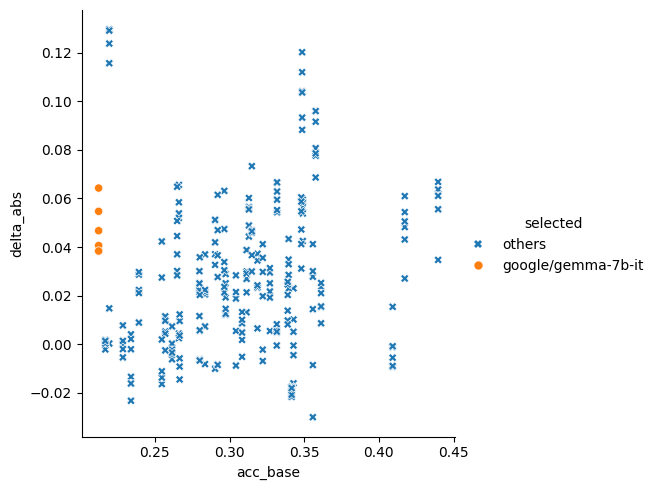

In [ ]:
display(Markdown(
  "### Average baseline accuracy (x) and marginal accuracy gain (y) of LLMs in Open CoT Leaderboard\n\n"
  "(Displaying six dots per LLM, one for each regime.)"
))
plot_avg_acc(w.value)